In [2]:
# Clone the YOLOv9 repository
!git clone https://github.com/carlosfab/yolov9.git
# Change the current working directory to the cloned YOLOv9 repository
%cd yolov9
# Install the necessary YOLOv9 dependencies from the requirements.txt file
!pip install -r requirements.txt -q
! pip install ultralytics


Cloning into 'yolov9'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 372 (delta 183), reused 177 (delta 177), pack-reused 125
Receiving objects: 100% (372/372), 2.53 MiB | 25.36 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 6.1 MB/s eta 0:00:00


In [3]:
! pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [4]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from itertools import chain
from glob import glob
from collections import Counter
from pprint import pprint

id2class_map = {
    '0' : 'with helmet',
    '1' : 'without helmet',
    '2' : 'rider',
    '3' : 'number_plate'
}

main_path = "/content/drive/MyDrive/YOLO_V9"

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 21
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 24,
 '3. number_plate': 22}



In [7]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/content/drive/MyDrive/YOLO_V9"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

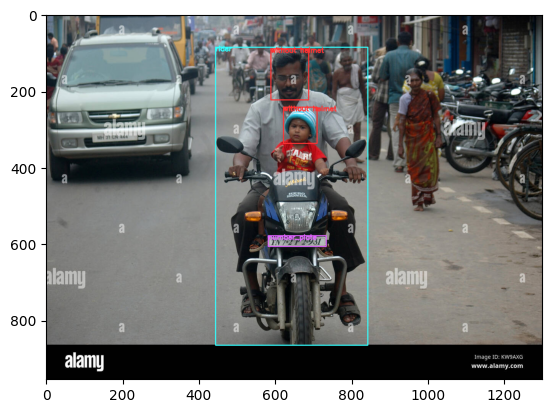

In [8]:
plot_image(image_name='new100')

In [9]:
from ultralytics import YOLO
model = YOLO("yolov9c.pt")
model.info

100%|██████████| 49.4M/49.4M [00:00<00:00, 219MB/s]


<bound method Model.info of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepConv(
                  (act): SiLU(inplace=True)
                  (conv1): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                  (conv2): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                )
                (cv2): Conv(
                  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                  (act): SiLU(inplace=True)
                )
              )
            )
          )
          (1): Conv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
        )
        (cv3): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepCon

In [10]:
import yaml

with open(os.path.join(main_path,'coco128.yaml'), 'r' ) as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [11]:
data = {
    'train' : '/content/drive/MyDrive/YOLO_V9/train',
    'val' : '/content/drive/MyDrive/YOLO_V9/val',
    'nc' : 4,
    'names' : [
        'with helmet',
        'without helmet',
        'rider',
        'number_plate'
    ]
}

with open('/content/drive/MyDrive/YOLO_V9/working/data.yaml','w') as file:
    yaml.dump(data,file)

with open('/content/drive/MyDrive/YOLO_V9/working/data.yaml','r') as file:
    print(file.read())


names:
- with helmet
- without helmet
- rider
- number_plate
nc: 4
train: /content/drive/MyDrive/YOLO_V9/train
val: /content/drive/MyDrive/YOLO_V9/val



In [12]:
os.environ["WANDB_MODE"] = "disabled"

model.train(
    data = '/content/drive/MyDrive/YOLO_V9/working/data.yaml',
    epochs = 50,
    workers = 1,
    batch = 8,
)

Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/drive/MyDrive/YOLO_V9/working/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 68.2MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/YOLO_V9/train/labels.cache... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/YOLO_V9/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/YOLO_V9/train/images/new128.jpg'
train: WARNING ⚠️ /content/drive/MyDrive/YOLO_V9/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'pfm', 'jpg', 'webp', 'bmp', 'jpeg', 'tif', 'tiff', 'png', 'dng', 'mpo'}
videos: {'avi', 'm4v', 'gif', 'mp4', 'mov', 'ts', 'wmv', 'mpg', 'mpeg', 'webm', 'asf', 'mkv'}


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/YOLO_V9/val/labels.cache... 21 images, 4 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.09G      1.066      2.586      1.344         53        640: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         25         74      0.732      0.485      0.503      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.87G      0.822       1.31      1.115         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         25         74      0.748      0.804      0.847      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.87G     0.8427      1.128      1.115         43        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         25         74      0.565      0.772       0.68      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.88G     0.8961      1.029      1.162         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         25         74      0.608      0.618      0.617      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.86G     0.9772      1.012      1.247         55        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         25         74      0.612      0.698       0.66      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.81G     0.9159      1.072      1.178         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         25         74      0.512      0.512      0.508      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.86G      0.944      1.038      1.231         34        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         25         74      0.527      0.603      0.533      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.79G      1.041      1.105      1.255         43        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         25         74      0.522      0.512      0.536      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.86G      1.006     0.9806      1.255         61        640: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         25         74      0.506      0.594      0.549      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.86G     0.9854      1.023      1.201         51        640: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         25         74      0.464      0.419      0.338      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.85G     0.9439     0.9335      1.211         35        640: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         25         74      0.594      0.743      0.698       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.85G     0.9071     0.8191      1.221         39        640: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         25         74       0.63      0.638      0.627      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.88G     0.8646     0.7398      1.154         48        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


                   all         25         74      0.613      0.657      0.685      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.88G     0.8535     0.6923       1.14         41        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         25         74      0.703      0.757      0.775      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.86G     0.8613     0.6704       1.14         62        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         25         74      0.649      0.814      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       5.8G     0.8001     0.6317      1.126         40        640: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         25         74      0.632      0.803      0.736      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.86G     0.7982     0.6374      1.139         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         25         74       0.75      0.793      0.768      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.85G     0.8109      0.619      1.122         28        640: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         25         74      0.777      0.838      0.787       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.87G     0.7616     0.5787       1.13         47        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         25         74      0.786       0.85       0.84      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.86G     0.7951     0.5996      1.117         37        640: 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         25         74       0.69      0.821      0.809      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.86G     0.7917      0.603      1.119         49        640: 100%|██████████| 13/13 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         25         74      0.753      0.758       0.82      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.86G     0.7387     0.5692       1.09         52        640: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         25         74      0.875      0.869      0.877      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.86G     0.7583     0.5848      1.108         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         25         74      0.814      0.792      0.843      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.8G     0.8001      0.577      1.112         44        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


                   all         25         74      0.819      0.826       0.84      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.87G     0.7237     0.5243      1.054         51        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         25         74      0.772      0.847      0.828      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.86G     0.7157       0.52      1.079         40        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         25         74       0.75       0.83      0.804      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.85G     0.7049      0.505      1.068         35        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         25         74      0.809       0.84       0.86      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.85G       0.67     0.4933      1.045         57        640: 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         25         74      0.827      0.854      0.875      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.87G     0.6519     0.4713      1.049         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         25         74      0.801      0.848      0.887      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.87G     0.6377     0.4615      1.034         41        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         25         74      0.848      0.873      0.893        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.86G     0.6732     0.4735       1.04         49        640: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         25         74      0.803      0.888      0.887      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       5.8G     0.6403     0.4616      1.036         32        640: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         25         74      0.836      0.839      0.888      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.86G     0.5973      0.453      1.015         33        640: 100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         25         74      0.771      0.881      0.886      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.86G     0.6214     0.4488      1.042         57        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         25         74      0.786      0.869      0.891      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.86G     0.6092     0.4609      1.028         52        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         25         74      0.817       0.87       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.86G      0.617     0.4449      1.019         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         25         74      0.866      0.803       0.89      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.86G     0.5854     0.4306     0.9921         43        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


                   all         25         74      0.824      0.866      0.892      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.87G     0.5562     0.4255      1.028         50        640: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         25         74      0.796      0.905       0.89      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.86G     0.5494     0.4187      1.004         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         25         74      0.821      0.878        0.9      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.79G     0.5519     0.3925     0.9899         49        640: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         25         74      0.857      0.863      0.889      0.732


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      41/50      5.87G     0.4999     0.4485     0.9912         23        640: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         25         74      0.855      0.886      0.881       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.87G     0.5044       0.36     0.9584         22        640: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         25         74      0.826      0.886      0.861      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.86G      0.501     0.3635     0.9582         31        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         25         74      0.816      0.853      0.851      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.85G     0.4871     0.3754     0.9442         18        640: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         25         74      0.831      0.832      0.867      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.87G     0.4517     0.3407     0.9236         19        640: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         25         74      0.847      0.831      0.876      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.87G     0.4446     0.3238     0.9209         20        640: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         25         74      0.815      0.868      0.888      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.87G     0.4711     0.3207     0.9176         22        640: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         25         74      0.828       0.88      0.893       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       5.8G     0.4463     0.3214     0.9349         20        640: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         25         74      0.833      0.879      0.887      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.86G      0.436     0.3182     0.9487         19        640: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         25         74      0.838       0.88      0.889      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.86G     0.4332     0.3069     0.9392         17        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


                   all         25         74      0.847      0.851      0.889      0.742

50 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.19 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


                   all         25         74      0.833      0.879      0.887      0.742
           with helmet         25         13      0.863      0.846       0.83      0.651
        without helmet         25         15       0.68       0.85       0.86       0.69
                 rider         25         24      0.845       0.91      0.896      0.808
          number_plate         25         22      0.942      0.909      0.963      0.821
Speed: 0.3ms preprocess, 15.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a91cf974d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [13]:
from ultralytics import YOLO

model = YOLO('/content/yolov9/runs/detect/train/weights/best.pt')


In [14]:
# use results from `model.predict()` for plotting
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

In [28]:
def label_image(image_path):
    # Görüntüyü yükleme
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded.")

    # Görüntü boyutlarını alma
    original_shape = image.shape[:2]  # (height, width)

    # YOLO modelini kullanarak tahminler yapma
    results = model(image)

    # Tahmin edilen nesneleri al
    labels = results[0].boxes.data.cpu().numpy()  # YOLOv8 için results[0].boxes.data
    predicted_labels = []

    for label in labels:
        x_min, y_min, x_max, y_max, confidence, class_id = label[:6]  # İlk 6 elemanı al
        x_center = (x_min + x_max) / 2 / original_shape[1]
        y_center = (y_min + y_max) / 2 / original_shape[0]
        width = (x_max - x_min) / original_shape[1]
        height = (y_max - y_min) / original_shape[0]
        predicted_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return predicted_labels

def save_labels(labels, label_path):
    # Etiketleri dosyaya yazma
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(f"{label}\n")




0: 640x608 2 without helmets, 1 rider, 49.9ms
Speed: 4.7ms preprocess, 49.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 608)
The predicted labels for the image are saved to: /content/drive/MyDrive/YOLO_V9/val/labels/new404.txt
prediction ↓

image 1/1 /content/drive/MyDrive/YOLO_V9/val/images/new404.jpg: 640x608 2 without helmets, 1 rider, 48.7ms
Speed: 2.9ms preprocess, 48.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 608)


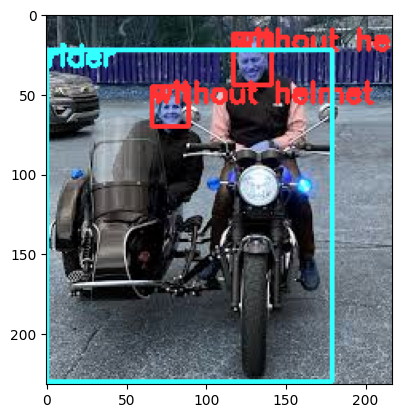

actual image ↓


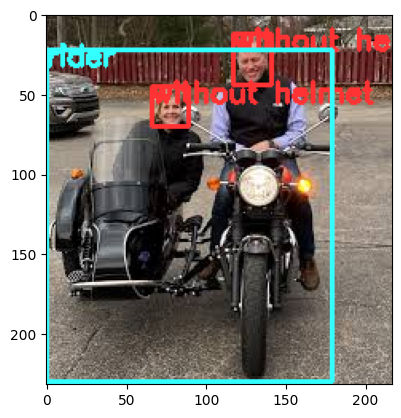

In [29]:
# Örnek kullanım
image_path = '/content/drive/MyDrive/YOLO_V9/val/images/new404.jpg'
label_path = '/content/drive/MyDrive/YOLO_V9/val/labels/new404.txt'

# Etiket klasörünün var olup olmadığını kontrol et ve gerekirse oluştur
os.makedirs(os.path.dirname(label_path), exist_ok=True)

try:
    predicted_labels = label_image(image_path)
    save_labels(predicted_labels, label_path)
    print(f'The predicted labels for the image are saved to: {label_path}')
except Exception as e:
    print(f"Error: {e}")

image_name = 'new404'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')
